# ActiveSurrogate: Automatic Surrogate Modeling with Active Learning

This notebook demonstrates how to use the `ActiveSurrogate` class to automatically build surrogate models using active learning. The system intelligently samples an input domain to minimize expensive function evaluations while building an accurate surrogate model.

## Key Features

- **Automatic Sampling**: Starts with Latin Hypercube sampling, then uses active learning to select informative points
- **Multiple Acquisition Functions**: Expected Improvement (EI), Upper Confidence Bound (UCB), Probability of Improvement (PI), Maximum Variance
- **Flexible Stopping Criteria**: Mean ratio, percentile-based, absolute threshold, convergence detection
- **Batch Support**: Can sample multiple points per iteration for parallel evaluation
- **History Tracking**: Records all metrics for analysis and visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from pycse.pyroxy import ActiveSurrogate

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Suppress sklearn numerical warnings for cleaner output
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.gaussian_process._gpr")
warnings.filterwarnings(
    "ignore", category=ConvergenceWarning, module="sklearn.gaussian_process._gpr"
)
warnings.filterwarnings(
    "ignore", category=ConvergenceWarning, module="sklearn.gaussian_process.kernels"
)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.exceptions")

## Example 1: Basic Usage with a 1D Function

Let's start with a simple 1D function that has some interesting features (multiple local minima).

In [3]:
# Define a moderately complex test function
def expensive_function(X):
    """A function with multiple local minima."""
    x = X.flatten()
    return np.sin(x) + 0.5 * np.sin(3 * x) + 0.1 * x


# Define the domain
bounds = [(0, 10)]

# Create a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# Build the surrogate with active learning
print("Building surrogate with Expected Improvement acquisition...")
surrogate, history = ActiveSurrogate.build(
    func=expensive_function,
    bounds=bounds,
    model=model,
    acquisition="ei",
    stopping_criterion="mean_ratio",
    stopping_threshold=1.5,
    n_initial=5,
    max_iterations=20,
    verbose=True,
)

print(f"\nFinal surrogate built with {len(surrogate.xtrain)} samples")

Building surrogate with Expected Improvement acquisition...
Initialized with 5 LHS samples
Iteration 0/20
  Samples: 6
  Best acquisition: 0.0171
  Mean uncertainty: 0.2248
  Max uncertainty: 0.8510
Iteration 1/20
  Samples: 7
  Best acquisition: 0.0559
  Mean uncertainty: 0.3459
  Max uncertainty: 1.0241
Iteration 2/20
  Samples: 8
  Best acquisition: 0.1061
  Mean uncertainty: 0.4127
  Max uncertainty: 0.9749
Iteration 3/20
  Samples: 9
  Best acquisition: 0.2450
  Mean uncertainty: 0.4319
  Max uncertainty: 1.0511
Iteration 4/20
  Samples: 10
  Best acquisition: 0.0948
  Mean uncertainty: 0.3761
  Max uncertainty: 0.9795
Iteration 5/20
  Samples: 11
  Best acquisition: 0.0814
  Mean uncertainty: 0.3129
  Max uncertainty: 0.9939
Iteration 6/20
  Samples: 12
  Best acquisition: 0.0760
  Mean uncertainty: 0.2223
  Max uncertainty: 0.8162
Iteration 7/20
  Samples: 13
  Best acquisition: 0.0475
  Mean uncertainty: 0.1891
  Max uncertainty: 0.8302
Iteration 8/20
  Samples: 14
  Best acqui

### Visualize the Results

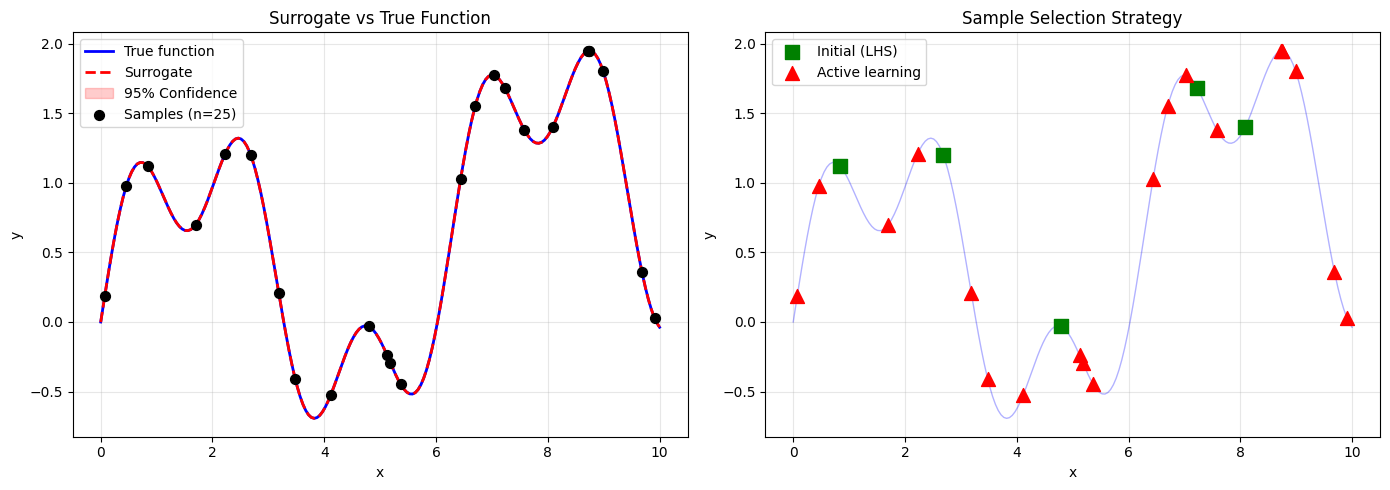


Surrogate Accuracy:
  RMSE: 0.0002
  Max Error: 0.0010
  Mean Uncertainty (σ): 0.0002
  Max Uncertainty (σ): 0.0028


In [4]:
# Create test points
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = expensive_function(X_plot)
y_pred = surrogate(X_plot)

# Get uncertainty estimates from the model
y_pred_with_std, y_std = surrogate.model.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(14, 5))

# Left: Surrogate vs True Function with Uncertainty
plt.subplot(1, 2, 1)
plt.plot(X_plot, y_true, "b-", label="True function", linewidth=2)
plt.plot(X_plot, y_pred, "r--", label="Surrogate", linewidth=2)
# Plot 95% confidence interval (±2σ)
plt.fill_between(
    X_plot.flatten(),
    (y_pred_with_std - 2 * y_std).flatten(),
    (y_pred_with_std + 2 * y_std).flatten(),
    alpha=0.2,
    color="red",
    label="95% Confidence",
)
plt.scatter(
    surrogate.xtrain,
    surrogate.ytrain,
    c="black",
    s=50,
    label=f"Samples (n={len(surrogate.xtrain)})",
    zorder=5,
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Surrogate vs True Function")
plt.grid(True, alpha=0.3)

# Right: Sample locations over iterations
plt.subplot(1, 2, 2)
# Mark initial samples
plt.scatter(
    surrogate.xtrain[:5],
    surrogate.ytrain[:5],
    c="green",
    s=100,
    marker="s",
    label="Initial (LHS)",
    zorder=5,
)
# Mark actively selected samples
if len(surrogate.xtrain) > 5:
    plt.scatter(
        surrogate.xtrain[5:],
        surrogate.ytrain[5:],
        c="red",
        s=100,
        marker="^",
        label="Active learning",
        zorder=5,
    )
plt.plot(X_plot, y_true, "b-", alpha=0.3, linewidth=1)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Sample Selection Strategy")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print accuracy metrics
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
print("\nSurrogate Accuracy:")
print(f"  RMSE: {rmse:.4f}")
print(f"  Max Error: {np.max(np.abs(y_pred - y_true)):.4f}")
print(f"  Mean Uncertainty (σ): {np.mean(y_std):.4f}")
print(f"  Max Uncertainty (σ): {np.max(y_std):.4f}")

### Analyze the Training History

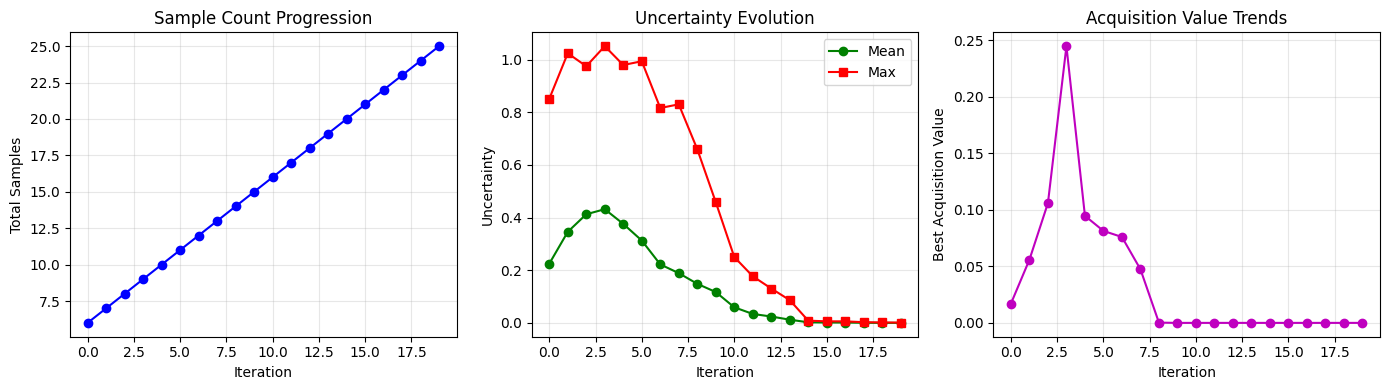

In [5]:
plt.figure(figsize=(14, 4))

# Sample progression
plt.subplot(1, 3, 1)
plt.plot(history["iterations"], history["n_samples"], "b-o")
plt.xlabel("Iteration")
plt.ylabel("Total Samples")
plt.title("Sample Count Progression")
plt.grid(True, alpha=0.3)

# Uncertainty evolution
plt.subplot(1, 3, 2)
plt.plot(history["iterations"], history["mean_uncertainty"], "g-o", label="Mean")
plt.plot(history["iterations"], history["max_uncertainty"], "r-s", label="Max")
plt.xlabel("Iteration")
plt.ylabel("Uncertainty")
plt.legend()
plt.title("Uncertainty Evolution")
plt.grid(True, alpha=0.3)

# Acquisition values
plt.subplot(1, 3, 3)
plt.plot(history["iterations"], history["acquisition_values"], "m-o")
plt.xlabel("Iteration")
plt.ylabel("Best Acquisition Value")
plt.title("Acquisition Value Trends")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example 2: Comparing Different Acquisition Functions

Different acquisition functions have different exploration/exploitation trade-offs. Let's compare them:

In [6]:
acquisition_functions = ["ei", "ucb", "pi", "variance"]
acquisition_names = {
    "ei": "Expected Improvement",
    "ucb": "Upper Confidence Bound",
    "pi": "Probability of Improvement",
    "variance": "Maximum Variance",
}

results = {}

for acq in acquisition_functions:
    print(f"\nTesting {acquisition_names[acq]}...")

    # Create fresh model for each test
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

    # Build surrogate
    surrogate, history = ActiveSurrogate.build(
        func=expensive_function,
        bounds=bounds,
        model=model,
        acquisition=acq,
        stopping_criterion="absolute",
        stopping_threshold=0.15,
        n_initial=5,
        max_iterations=15,
        verbose=False,
    )

    # Evaluate accuracy
    y_pred = surrogate(X_plot)
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

    results[acq] = {
        "surrogate": surrogate,
        "history": history,
        "y_pred": y_pred,
        "rmse": rmse,
        "n_samples": len(surrogate.xtrain),
    }

    print(f"  Samples used: {results[acq]['n_samples']}")
    print(f"  RMSE: {rmse:.4f}")


Testing Expected Improvement...
  Samples used: 17
  RMSE: 0.0070

Testing Upper Confidence Bound...
  Samples used: 20
  RMSE: 0.1225

Testing Probability of Improvement...
  Samples used: 17
  RMSE: 0.0302

Testing Maximum Variance...
  Samples used: 16
  RMSE: 0.0055


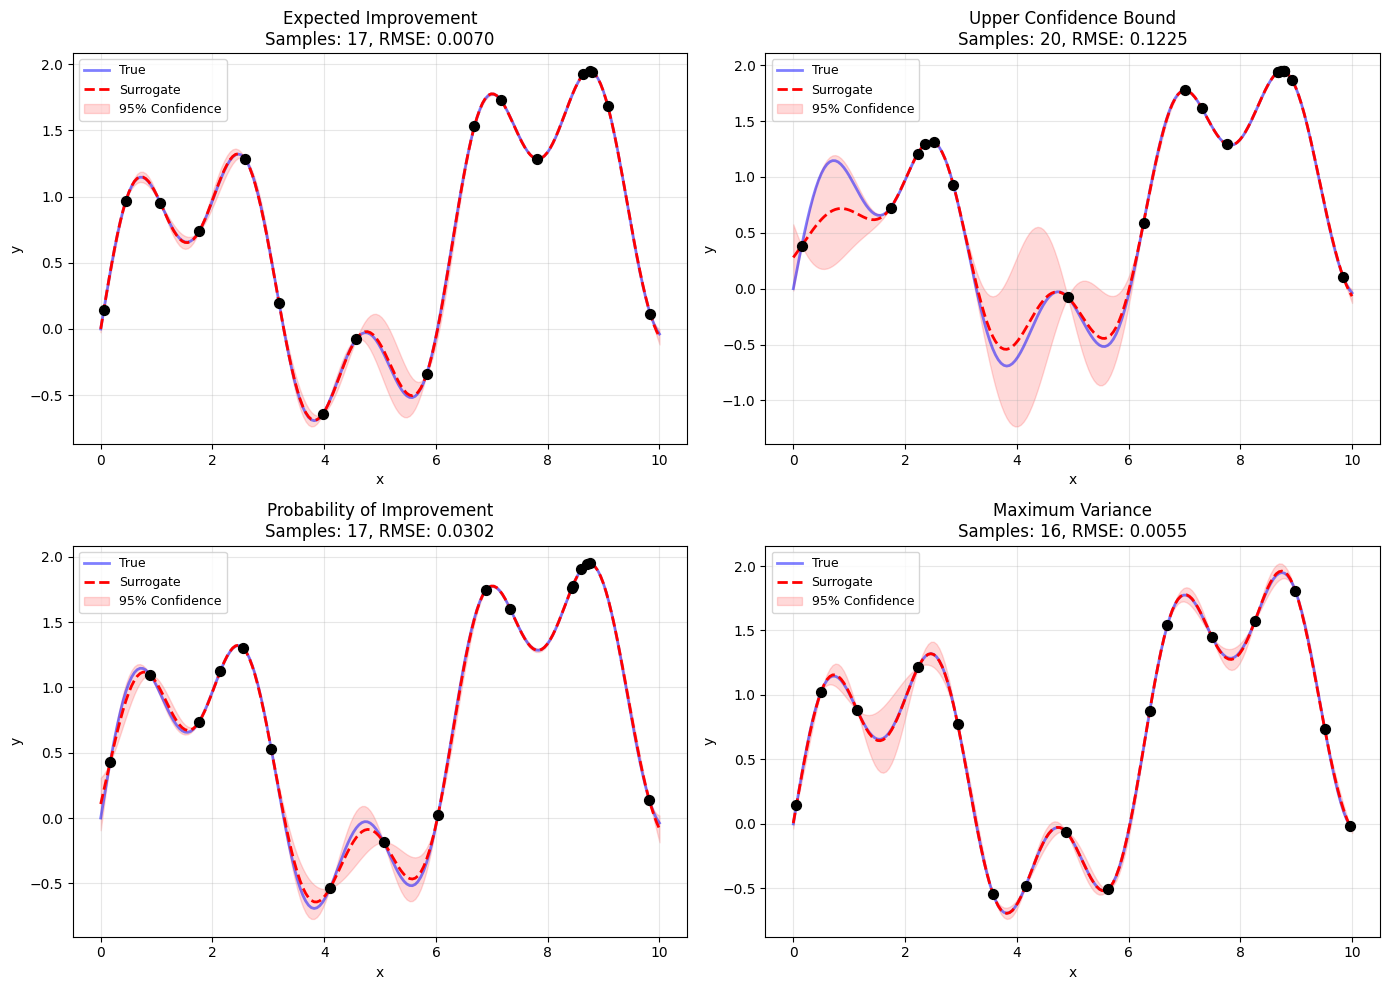


Summary Comparison:
Acquisition               Samples    RMSE      
---------------------------------------------
Expected Improvement      17         0.0070    
Upper Confidence Bound    20         0.1225    
Probability of Improvement 17         0.0302    
Maximum Variance          16         0.0055    


In [7]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, acq in enumerate(acquisition_functions):
    ax = axes[idx]
    surrogate = results[acq]["surrogate"]

    # Get predictions with uncertainty
    y_pred_with_std, y_std = surrogate.model.predict(X_plot, return_std=True)

    # Plot true function and surrogate
    ax.plot(X_plot, y_true, "b-", label="True", linewidth=2, alpha=0.5)
    ax.plot(X_plot, results[acq]["y_pred"], "r--", label="Surrogate", linewidth=2)

    # Plot 95% confidence interval
    ax.fill_between(
        X_plot.flatten(),
        (y_pred_with_std - 2 * y_std).flatten(),
        (y_pred_with_std + 2 * y_std).flatten(),
        alpha=0.15,
        color="red",
        label="95% Confidence",
    )

    # Plot sample points
    ax.scatter(surrogate.xtrain, surrogate.ytrain, c="black", s=50, zorder=5)

    ax.set_title(
        f"{acquisition_names[acq]}\n"
        f"Samples: {results[acq]['n_samples']}, RMSE: {results[acq]['rmse']:.4f}"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\nSummary Comparison:")
print(f"{'Acquisition':<25} {'Samples':<10} {'RMSE':<10}")
print("-" * 45)
for acq in acquisition_functions:
    print(
        f"{acquisition_names[acq]:<25} {results[acq]['n_samples']:<10} {results[acq]['rmse']:<10.4f}"
    )

## Example 3: 2D Function with Visualization

Let's demonstrate active learning on a 2D function.

In [8]:
# Define 2D test function
def func_2d(X):
    """2D test function with interesting features."""
    x1, x2 = X[:, 0], X[:, 1]
    return np.sin(x1) * np.cos(x2) + 0.1 * x1


# Define 2D domain
bounds_2d = [(0, 2 * np.pi), (0, 2 * np.pi)]

# Create model
kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e2))
model_2d = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# Build surrogate
print("Building 2D surrogate...")
surrogate_2d, history_2d = ActiveSurrogate.build(
    func=func_2d,
    bounds=bounds_2d,
    model=model_2d,
    acquisition="ei",
    stopping_criterion="mean_ratio",
    stopping_threshold=2.0,
    n_initial=10,
    max_iterations=20,
    verbose=True,
)

print(f"\n2D Surrogate built with {len(surrogate_2d.xtrain)} samples")

Building 2D surrogate...
Initialized with 10 LHS samples
Iteration 0/20
  Samples: 11
  Best acquisition: 0.0665
  Mean uncertainty: 0.2990
  Max uncertainty: 0.5414
Iteration 1/20
  Samples: 12
  Best acquisition: 0.1476
  Mean uncertainty: 0.3078
  Max uncertainty: 0.6297
Iteration 2/20
  Samples: 13
  Best acquisition: 0.0391
  Mean uncertainty: 0.2627
  Max uncertainty: 0.6463
Iteration 3/20
  Samples: 14
  Best acquisition: 0.0040
  Mean uncertainty: 0.2310
  Max uncertainty: 0.6394
Iteration 4/20
  Samples: 15
  Best acquisition: 0.0020
  Mean uncertainty: 0.2059
  Max uncertainty: 0.6064
Iteration 5/20
  Samples: 16
  Best acquisition: 0.0015
  Mean uncertainty: 0.1760
  Max uncertainty: 0.4492
Iteration 6/20
  Samples: 17
  Best acquisition: 0.0010
  Mean uncertainty: 0.1519
  Max uncertainty: 0.4385
Iteration 7/20
  Samples: 18
  Best acquisition: 0.0010
  Mean uncertainty: 0.1769
  Max uncertainty: 0.4673
Iteration 8/20
  Samples: 19
  Best acquisition: 0.0005
  Mean uncertai

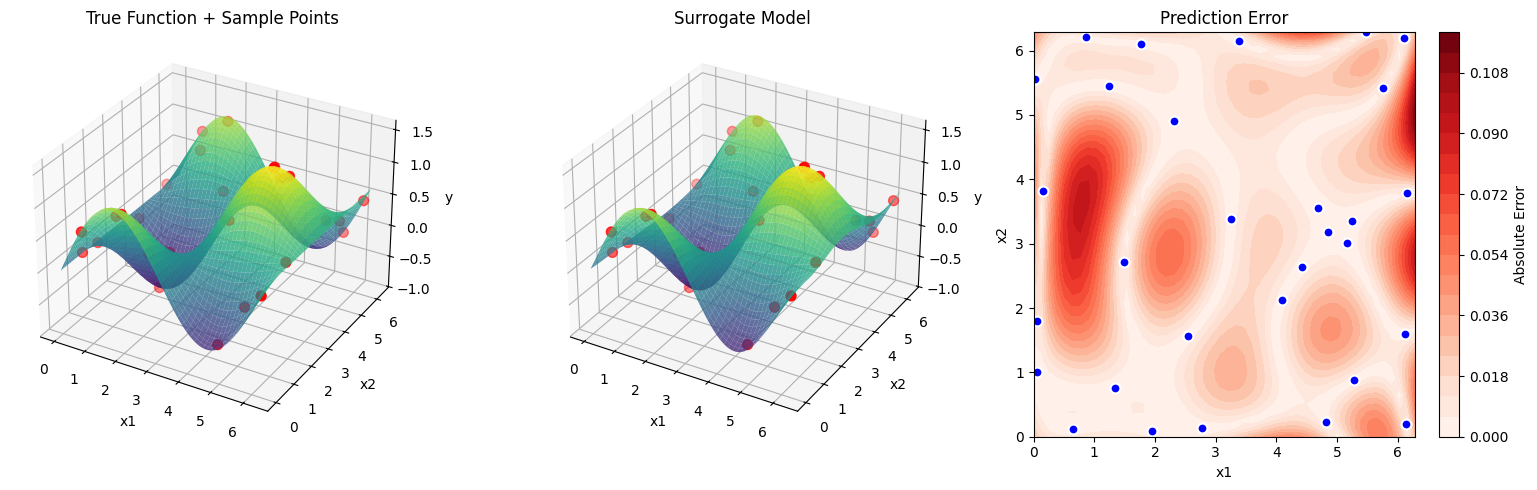


2D Surrogate Statistics:
  Mean Absolute Error: 0.0215
  Max Absolute Error: 0.1141
  RMSE: 0.0299


In [9]:
# Create meshgrid for visualization
x1_grid = np.linspace(0, 2 * np.pi, 50)
x2_grid = np.linspace(0, 2 * np.pi, 50)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

# Evaluate true function and surrogate
y_true_2d = func_2d(X_grid).reshape(X1.shape)
y_pred_2d = surrogate_2d(X_grid).reshape(X1.shape)

# Visualize
fig = plt.figure(figsize=(16, 5))

# True function
ax1 = fig.add_subplot(131, projection="3d")
surf1 = ax1.plot_surface(X1, X2, y_true_2d, cmap="viridis", alpha=0.8)
ax1.scatter(
    surrogate_2d.xtrain[:, 0],
    surrogate_2d.xtrain[:, 1],
    surrogate_2d.ytrain,
    c="red",
    s=50,
    marker="o",
)
ax1.set_title("True Function + Sample Points")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_zlabel("y")

# Surrogate
ax2 = fig.add_subplot(132, projection="3d")
surf2 = ax2.plot_surface(X1, X2, y_pred_2d, cmap="viridis", alpha=0.8)
ax2.scatter(
    surrogate_2d.xtrain[:, 0],
    surrogate_2d.xtrain[:, 1],
    surrogate_2d.ytrain,
    c="red",
    s=50,
    marker="o",
)
ax2.set_title("Surrogate Model")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("y")

# Error
ax3 = fig.add_subplot(133)
error = np.abs(y_true_2d - y_pred_2d)
contour = ax3.contourf(X1, X2, error, levels=20, cmap="Reds")
ax3.scatter(
    surrogate_2d.xtrain[:, 0],
    surrogate_2d.xtrain[:, 1],
    c="blue",
    s=50,
    marker="o",
    edgecolors="white",
    linewidths=1.5,
)
plt.colorbar(contour, ax=ax3, label="Absolute Error")
ax3.set_title("Prediction Error")
ax3.set_xlabel("x1")
ax3.set_ylabel("x2")

plt.tight_layout()
plt.show()

print("\n2D Surrogate Statistics:")
print(f"  Mean Absolute Error: {np.mean(error):.4f}")
print(f"  Max Absolute Error: {np.max(error):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(error**2)):.4f}")

## Example 4: Using Batch Mode for Parallel Evaluation

When your function can be evaluated in parallel, batch mode samples multiple points per iteration.

In [10]:
# Build surrogate with batch sampling
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
model_batch = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

print("Building surrogate with batch_size=3...")
surrogate_batch, history_batch = ActiveSurrogate.build(
    func=expensive_function,
    bounds=bounds,
    model=model_batch,
    acquisition="ucb",
    batch_size=3,  # Sample 3 points per iteration
    stopping_criterion="absolute",
    stopping_threshold=0.15,
    n_initial=5,
    max_iterations=10,
    verbose=True,
)

print(f"\nBatch surrogate built with {len(surrogate_batch.xtrain)} samples")
print(f"Iterations run: {len(history_batch['iterations'])}")
print(
    f"Average samples per iteration: {(len(surrogate_batch.xtrain) - 5) / len(history_batch['iterations']):.1f}"
)

Building surrogate with batch_size=3...
Initialized with 5 LHS samples
Iteration 0/10
  Samples: 8
  Best acquisition: 1.8496
  Mean uncertainty: 0.8479
  Max uncertainty: 0.8546
Iteration 1/10
  Samples: 11
  Best acquisition: 3.3595
  Mean uncertainty: 0.0603
  Max uncertainty: 0.6996
Iteration 2/10
  Samples: 14
  Best acquisition: 1.9860
  Mean uncertainty: 0.2325
  Max uncertainty: 1.0153
Iteration 3/10
  Samples: 17
  Best acquisition: 1.9414
  Mean uncertainty: 0.1525
  Max uncertainty: 0.5738
Iteration 4/10
  Samples: 20
  Best acquisition: 1.9489
  Mean uncertainty: 0.1369
  Max uncertainty: 0.5624
Iteration 5/10
  Samples: 23
  Best acquisition: 1.9092
  Mean uncertainty: 0.1360
  Max uncertainty: 0.5604
Iteration 6/10
  Samples: 26
  Best acquisition: 1.9423
  Mean uncertainty: 0.1328
  Max uncertainty: 0.5578
Iteration 7/10
  Samples: 29
  Best acquisition: 1.9474
  Mean uncertainty: 0.1173
  Max uncertainty: 0.5232
Iteration 8/10
  Samples: 32
  Best acquisition: 1.9472
  

## Example 5: Custom Callback for Monitoring

You can provide a callback function to monitor or log the training process.

Building surrogate with custom callback...
  [Callback] Iteration 0: Mean uncertainty = 0.1369
  [Callback] Iteration 5: Mean uncertainty = 0.2922
  [Callback] Iteration 10: Mean uncertainty = 0.0787
  [Callback] Iteration 15: Mean uncertainty = 0.0037
  [Callback] Iteration 20: Mean uncertainty = 0.0008

Callback tracked 25 iterations


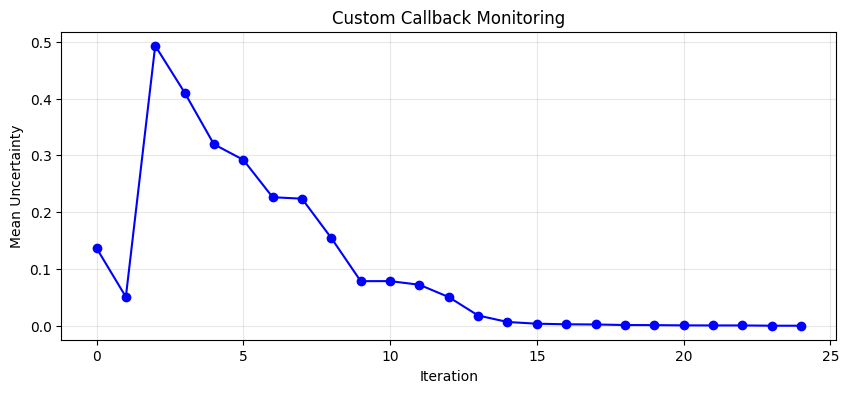

In [11]:
# Define a custom callback
callback_data = {"iterations": [], "uncertainties": []}


def my_callback(iteration, history):
    """Custom callback to track specific metrics."""
    callback_data["iterations"].append(iteration)
    callback_data["uncertainties"].append(history["mean_uncertainty"][-1])

    if iteration % 5 == 0:
        print(
            f"  [Callback] Iteration {iteration}: Mean uncertainty = {history['mean_uncertainty'][-1]:.4f}"
        )


# Build surrogate with callback
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
model_cb = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

print("Building surrogate with custom callback...")
surrogate_cb, history_cb = ActiveSurrogate.build(
    func=expensive_function,
    bounds=bounds,
    model=model_cb,
    acquisition="ei",
    stopping_criterion="convergence",
    stopping_threshold=0.05,
    n_initial=5,
    max_iterations=25,
    callback=my_callback,
    verbose=False,
)

print(f"\nCallback tracked {len(callback_data['iterations'])} iterations")

# Plot callback data
plt.figure(figsize=(10, 4))
plt.plot(callback_data["iterations"], callback_data["uncertainties"], "b-o")
plt.xlabel("Iteration")
plt.ylabel("Mean Uncertainty")
plt.title("Custom Callback Monitoring")
plt.grid(True, alpha=0.3)
plt.show()

## Summary

This notebook demonstrated:

1. **Basic Usage**: Building a surrogate with default settings
2. **Acquisition Functions**: Comparing EI, UCB, PI, and variance-based strategies
3. **2D Functions**: Extending to multi-dimensional problems
4. **Batch Mode**: Sampling multiple points per iteration for parallel evaluation
5. **Custom Callbacks**: Monitoring and logging during training
6. **Noisy Functions**: Handling experimental noise with WhiteKernel and GP regression

### Key Takeaways

- **Expected Improvement (EI)** balances exploration and exploitation well for optimization
- **Maximum Variance** is best for pure space-filling and coverage
- **Batch mode** with hallucination provides diverse samples for parallel evaluation
- **Stopping criteria** can be tuned based on your accuracy requirements
- **WhiteKernel** enables GPs to model observation noise and filter it from the underlying function
- The returned surrogate is a standard `_Surrogate` object that can be used like any other pyroxy surrogate

### When to Use ActiveSurrogate

- Your function is expensive to evaluate (simulations, experiments, etc.)
- You want to minimize the number of function evaluations
- You need a surrogate model for optimization or analysis
- You want automatic, intelligent sampling rather than manual grid selection
- Your measurements contain noise (use WhiteKernel or set `alpha` parameter)

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel


# Define the true underlying function (noise-free)
def true_function(X):
    """The true underlying function without noise."""
    x = X.flatten()
    return np.sin(x) + 0.5 * np.sin(3 * x) + 0.1 * x


# Define a noisy version that simulates experimental measurements
noise_level = 0.2
rng = np.random.RandomState(42)


def noisy_function(X):
    """Function with measurement noise (simulates real experiments)."""
    y_true = true_function(X)
    noise = rng.normal(0, noise_level, size=y_true.shape)
    return y_true + noise


# Create a GP model with WhiteKernel to explicitly model noise
kernel_noisy = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(
    noise_level=noise_level**2, noise_level_bounds=(1e-5, 1.0)
)
model_noisy = GaussianProcessRegressor(kernel=kernel_noisy, n_restarts_optimizer=10)

# Build surrogate with active learning on noisy data
print("Building surrogate from noisy observations...")
print(f"Noise level: σ = {noise_level:.2f}")
surrogate_noisy, history_noisy = ActiveSurrogate.build(
    func=noisy_function,
    bounds=bounds,
    model=model_noisy,
    acquisition="ei",
    stopping_criterion="mean_ratio",
    stopping_threshold=1.5,
    n_initial=5,
    max_iterations=20,
    verbose=True,
)

print(f"\nNoisy surrogate built with {len(surrogate_noisy.xtrain)} samples")

# Visualize how the surrogate handles noisy data
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = true_function(X_plot)
y_pred_noisy = surrogate_noisy(X_plot)
y_pred_with_std, y_std = surrogate_noisy.model.predict(X_plot, return_std=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top left: Noisy observations vs true function
ax1 = axes[0, 0]
ax1.plot(X_plot, y_true, "b-", label="True function (noise-free)", linewidth=2)
ax1.scatter(
    surrogate_noisy.xtrain,
    surrogate_noisy.ytrain,
    c="red",
    s=80,
    alpha=0.6,
    label="Noisy observations",
    zorder=5,
)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data: Noisy Observations")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top right: Surrogate vs true function
ax2 = axes[0, 1]
ax2.plot(X_plot, y_true, "b-", label="True function", linewidth=2, alpha=0.7)
ax2.plot(X_plot, y_pred_noisy, "r--", label="Surrogate (filtered)", linewidth=2)
ax2.fill_between(
    X_plot.flatten(),
    (y_pred_with_std - 2 * y_std).flatten(),
    (y_pred_with_std + 2 * y_std).flatten(),
    alpha=0.2,
    color="red",
    label="95% Confidence",
)
ax2.scatter(surrogate_noisy.xtrain, surrogate_noisy.ytrain, c="gray", s=40, alpha=0.3, zorder=3)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Surrogate Filters Noise")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom left: Residuals
ax3 = axes[1, 0]
surrogate_at_train = surrogate_noisy(surrogate_noisy.xtrain.reshape(-1, 1))
residuals = surrogate_noisy.ytrain - surrogate_at_train
ax3.scatter(surrogate_noisy.xtrain, residuals, c="purple", s=80, alpha=0.6)
ax3.axhline(y=0, color="k", linestyle="--", linewidth=1)
ax3.axhline(
    y=noise_level, color="r", linestyle=":", linewidth=1, label=f"±{noise_level:.2f} (noise level)"
)
ax3.axhline(y=-noise_level, color="r", linestyle=":", linewidth=1)
ax3.set_xlabel("x")
ax3.set_ylabel("Residual")
ax3.set_title("Residuals: Noisy Data - Surrogate")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Bottom right: Prediction accuracy
ax4 = axes[1, 1]
error = np.abs(y_pred_noisy - y_true)
ax4.plot(X_plot, error, "g-", linewidth=2, label="Absolute Error")
ax4.axhline(
    y=noise_level,
    color="r",
    linestyle="--",
    linewidth=1,
    label=f"Noise level (σ={noise_level:.2f})",
)
ax4.fill_between(
    X_plot.flatten(), 0, noise_level, alpha=0.1, color="red", label="Within noise level"
)
ax4.set_xlabel("x")
ax4.set_ylabel("Absolute Error")
ax4.set_title("Surrogate Error vs True Function")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nNoisy Surrogate Performance:")
print(f"  Noise level in data: σ = {noise_level:.3f}")
print(f"  Learned noise level: σ = {np.sqrt(surrogate_noisy.model.kernel_.k2.noise_level):.3f}")
print("\nAccuracy on TRUE function (without noise):")
print(f"  RMSE: {np.sqrt(np.mean((y_pred_noisy - y_true) ** 2)):.4f}")
print(f"  Max Error: {np.max(np.abs(y_pred_noisy - y_true)):.4f}")
print(f"  Mean Error: {np.mean(np.abs(y_pred_noisy - y_true)):.4f}")
print("\nResiduals at training points:")
print(f"  Mean absolute residual: {np.mean(np.abs(residuals)):.4f}")
print(f"  Std of residuals: {np.std(residuals):.4f}")
print("\nThis demonstrates that the GP successfully:")
print(f"  1. Identified the noise level (~{noise_level:.2f})")
print("  2. Filtered noise to learn the underlying function")
print("  3. Maintained prediction accuracy within the noise level")

## Example 6: Learning from Noisy Observations

Real experimental data often contains measurement noise. Gaussian Processes can handle noise naturally by including it in the model using WhiteKernel. Let's demonstrate active learning on a noisy function and show how the GP filters noise to learn the underlying function.

In [ ]:
# Visualize how the surrogate handles noisy data
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = true_function(X_plot)
y_pred_noisy = surrogate_noisy(X_plot)

# Get predictions with uncertainty
y_pred_with_std, y_std = surrogate_noisy.model.predict(X_plot, return_std=True)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top left: Noisy observations vs true function
ax1 = axes[0, 0]
ax1.plot(X_plot, y_true, "b-", label="True function (noise-free)", linewidth=2)
ax1.scatter(
    surrogate_noisy.xtrain,
    surrogate_noisy.ytrain,
    c="red",
    s=80,
    alpha=0.6,
    label="Noisy observations",
    zorder=5,
)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data: Noisy Observations")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top right: Surrogate vs true function
ax2 = axes[0, 1]
ax2.plot(X_plot, y_true, "b-", label="True function", linewidth=2, alpha=0.7)
ax2.plot(X_plot, y_pred_noisy, "r--", label="Surrogate (filtered)", linewidth=2)
ax2.fill_between(
    X_plot.flatten(),
    (y_pred_with_std - 2 * y_std).flatten(),
    (y_pred_with_std + 2 * y_std).flatten(),
    alpha=0.2,
    color="red",
    label="95% Confidence",
)
ax2.scatter(
    surrogate_noisy.xtrain,
    surrogate_noisy.ytrain,
    c="gray",
    s=40,
    alpha=0.3,
    zorder=3,
)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Surrogate Filters Noise")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom left: Residuals (noisy observations vs surrogate)
ax3 = axes[1, 0]
surrogate_at_train = surrogate_noisy(surrogate_noisy.xtrain.reshape(-1, 1))
residuals = surrogate_noisy.ytrain - surrogate_at_train
ax3.scatter(surrogate_noisy.xtrain, residuals, c="purple", s=80, alpha=0.6)
ax3.axhline(y=0, color="k", linestyle="--", linewidth=1)
ax3.axhline(
    y=noise_level, color="r", linestyle=":", linewidth=1, label=f"±{noise_level:.2f} (noise level)"
)
ax3.axhline(y=-noise_level, color="r", linestyle=":", linewidth=1)
ax3.set_xlabel("x")
ax3.set_ylabel("Residual")
ax3.set_title("Residuals: Noisy Data - Surrogate")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Bottom right: Prediction accuracy on true function
ax4 = axes[1, 1]
error = np.abs(y_pred_noisy - y_true)
ax4.plot(X_plot, error, "g-", linewidth=2, label="Absolute Error")
ax4.axhline(
    y=noise_level,
    color="r",
    linestyle="--",
    linewidth=1,
    label=f"Noise level (σ={noise_level:.2f})",
)
ax4.fill_between(
    X_plot.flatten(),
    0,
    noise_level,
    alpha=0.1,
    color="red",
    label="Within noise level",
)
ax4.set_xlabel("x")
ax4.set_ylabel("Absolute Error")
ax4.set_title("Surrogate Error vs True Function")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nNoisy Surrogate Performance:")
print(f"  Noise level in data: σ = {noise_level:.3f}")
print(f"  Learned noise level: σ = {np.sqrt(surrogate_noisy.model.kernel_.k2.noise_level):.3f}")
print("\nAccuracy on TRUE function (without noise):")
print(f"  RMSE: {np.sqrt(np.mean((y_pred_noisy - y_true) ** 2)):.4f}")
print(f"  Max Error: {np.max(np.abs(y_pred_noisy - y_true)):.4f}")
print(f"  Mean Error: {np.mean(np.abs(y_pred_noisy - y_true)):.4f}")
print("\nResiduals at training points:")
print(f"  Mean absolute residual: {np.mean(np.abs(residuals)):.4f}")
print(f"  Std of residuals: {np.std(residuals):.4f}")
print("\nThis demonstrates that the GP successfully:")
print(f"  1. Identified the noise level (~{noise_level:.2f})")
print("  2. Filtered noise to learn the underlying function")
print("  3. Maintained prediction accuracy within the noise level")

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel


# Define the true underlying function (noise-free)
def true_function(X):
    """The true underlying function without noise."""
    x = X.flatten()
    return np.sin(x) + 0.5 * np.sin(3 * x) + 0.1 * x


# Define a noisy version that simulates experimental measurements
noise_level = 0.2
rng = np.random.RandomState(42)


def noisy_function(X):
    """Function with measurement noise (simulates real experiments)."""
    y_true = true_function(X)
    noise = rng.normal(0, noise_level, size=y_true.shape)
    return y_true + noise


# Create a GP model with WhiteKernel to explicitly model noise
# WhiteKernel models the observation noise variance
kernel_noisy = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(
    noise_level=noise_level**2, noise_level_bounds=(1e-5, 1.0)
)
model_noisy = GaussianProcessRegressor(kernel=kernel_noisy, n_restarts_optimizer=10)

# Build surrogate with active learning on noisy data
print("Building surrogate from noisy observations...")
print(f"Noise level: σ = {noise_level:.2f}")
surrogate_noisy, history_noisy = ActiveSurrogate.build(
    func=noisy_function,
    bounds=bounds,
    model=model_noisy,
    acquisition="ei",
    stopping_criterion="mean_ratio",
    stopping_threshold=1.5,
    n_initial=5,
    max_iterations=20,
    verbose=True,
)

print(f"\nNoisy surrogate built with {len(surrogate_noisy.xtrain)} samples")

## Example 6: Learning from Noisy Observations

Real experimental data often contains measurement noise. Gaussian Processes can handle noise naturally by including it in the model. Let's demonstrate active learning on a noisy function.